In [4]:
from torch import nn as tnn


class BlockTorch(tnn.Module):

    def __init__(self, kernel_size, channles):
        super().__init__()
        self.conv1d = tnn.Conv1d(
            in_channels=channles,
            out_channels=channles,
            bias=True,
            kernel_size=kernel_size,
            groups=channles,
            padding=kernel_size - 1,
        )

    def forward(
        self,
        x,
    ):
        batch_size, seq_len, _ = x.shape
        x = self.conv1d(x.transpose(1, 2))[..., :seq_len]
        return x.transpose(1, 2)

In [2]:
import os
os.environ["XLA_FLAGS"] = "--xla_dump_to='/home/liyanglu/flax_conv1d_test/hlo'"

In [5]:
from flax import linen as nn
import jax
import jax.numpy as jnp
#jax.config.update('jax_default_device', jax.devices('cpu')[0])

class BlockJAX_0(nn.Module):
  kernel_size: int
  channels: int
  kernel: jax.Array
  bias: jax.Array

  def setup(self):

    def kernel_init(key, shape, dtype):
      assert self.kernel.shape == shape
      return self.kernel.astype(dtype)
    
    def bias_init(key, shape, dtype):
      assert self.bias.shape == shape
      return self.bias.astype(dtype)

    self.conv1d = nn.Conv(features=self.channels,
                          kernel_size=[self.kernel_size],
                          feature_group_count=self.channels,
                          padding='CAUSAL',
                          use_bias=True,
                          kernel_init=kernel_init,
                          bias_init=bias_init,
                          )
    
  def __call__(self, x):
    x = self.conv1d(x)
    return x
  

class BlockJAX_1(nn.Module):
  kernel_size: int
  channels: int
  kernel: jax.Array
  bias: jax.Array

  def setup(self):

    def kernel_init(key, shape, dtype):
      assert self.kernel.shape == shape
      return self.kernel.astype(dtype)
    
    def bias_init(key, shape, dtype):
      assert self.bias.shape == shape
      return self.bias.astype(dtype)

    self.conv1d = nn.Conv(features=self.channels,
                          kernel_size=[self.kernel_size],
                          feature_group_count=self.channels,
                          padding=self.kernel_size - 1,
                          use_bias=True,
                          kernel_init=kernel_init,
                          bias_init=bias_init,
                          )
    
  def __call__(self, x):
    (b, l, d) = x.shape
    x = self.conv1d(x)[:, :l, :]
    return x

In [1]:
kernel_size = 4
channels = 5120

batch_size = 4
length = 4096

In [2]:
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(123456789)))

# prepare common weights and inputs
kernel = rs.normal(size=(kernel_size, 1, channels))
bias = rs.normal(size=(channels,))
input = rs.normal(size=(batch_size, length, channels))
grads_GT = np.array([[input[:, :i, :].sum(axis=(0, 1)) / (batch_size * length)] for i in range(length - kernel_size + 1, length + 1)])


In [6]:
import torch

# torch module forward and backward
torch.set_printoptions(precision=7)
conv_torch = BlockTorch(kernel_size, channels)
conv_torch.to(torch.bfloat16)
state_dict = conv_torch.state_dict()
state_dict["conv1d.weight"] = torch.from_numpy(kernel).to(torch.bfloat16).transpose(0, 2)
state_dict["conv1d.bias"] = torch.from_numpy(bias).to(torch.bfloat16)
conv_torch.load_state_dict(state_dict)
conv_torch.zero_grad()
output_torch = conv_torch(torch.from_numpy(input).to(torch.bfloat16))
loss_torch = output_torch.mean() * channels
loss_torch.backward()

loss_torch = loss_torch.detach().float().numpy()
output_torch = output_torch.detach().float().numpy()
grad_torch = conv_torch.conv1d.weight.grad.T.detach().float().numpy()

/tmp/ipykernel_2688751/3291828544.py:18: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  grad_torch = conv_torch.conv1d.weight.grad.T.detach().float().numpy()


In [7]:
import functools
import jax
import jax.numpy as jnp


# flax module forward and backward
def jax_forward_backward(model, params, input):
  def forward(params, input):
    output = model.apply(params, input)
    loss = jnp.mean(output) * channels
    return loss, output

  forward_backward_fn = jax.value_and_grad(forward, has_aux=True)
  (loss, output), grad = forward_backward_fn(params, input)
  return loss, output, grad

input_jax = jnp.array(input)
kernel_jax = jnp.array(kernel)
bias_jax = jnp.array(bias)

conv_jax_0 = BlockJAX_0(kernel_size, channels, kernel_jax, bias_jax)
rng = jax.random.key(0)
params_jax_0 = conv_jax_0.init(rng, input_jax)
jax_forward_backward_fn = functools.partial(jax_forward_backward, conv_jax_0)
jax_forward_backward_fn = jax.jit(jax_forward_backward_fn)
loss_jax_0, output_jax_0, grad_jax_0 = jax_forward_backward_fn(params_jax_0, input_jax)

loss_jax_0 = np.array(loss_jax_0)
output_jax_0 = np.array(output_jax_0)
grad_jax_0 = np.array(grad_jax_0["params"]["conv1d"]["kernel"])

conv_jax_1 = BlockJAX_1(kernel_size, channels, kernel_jax, bias_jax)
params_jax_1 = conv_jax_1.init(rng, input_jax)
jax_forward_backward_fn = functools.partial(jax_forward_backward, conv_jax_1)
jax_forward_backward_fn = jax.jit(jax_forward_backward_fn)
loss_jax_1, output_jax_1, grad_jax_1 = jax_forward_backward_fn(params_jax_1, input_jax)

loss_jax_1 = np.array(loss_jax_1)
output_jax_1 = np.array(output_jax_1)
grad_jax_1 = np.array(grad_jax_1["params"]["conv1d"]["kernel"])

In [8]:
print("================================================")
print(f"grad_GT: {grads_GT.shape}")
print(grads_GT)
print("================================================")
print(f"conv_torch.conv1d.weight.grad.T shape: {grad_torch.shape}")
print(grad_torch)
print("================================================")
print(f'grad_jax_0["params"]["conv1d"]["kernel"] {grad_jax_0.shape}')
print(grad_jax_0)
print("================================================")

grad_GT: (8, 1, 5120)
[[[-0.00565274 -0.00381728  0.00051747 ... -0.00307646 -0.00715068
   -0.02101874]]

 [[-0.00561152 -0.00372414  0.00050346 ... -0.00316179 -0.00743304
   -0.02108935]]

 [[-0.00559472 -0.00389052  0.00027056 ... -0.00326225 -0.00766431
   -0.02117832]]

 ...

 [[-0.00546652 -0.00366866  0.00017944 ... -0.00333533 -0.0074792
   -0.02112855]]

 [[-0.00557186 -0.00362588  0.00015699 ... -0.0033289  -0.00742658
   -0.02090513]]

 [[-0.00518729 -0.00358061  0.00012044 ... -0.00322864 -0.0074442
   -0.02076411]]]
conv_torch.conv1d.weight.grad.T shape: (8, 1, 5120)
[[[-0.00564575 -0.0038147   0.00052261 ... -0.00308228 -0.00714111
   -0.02099609]]

 [[-0.00561523 -0.00372314  0.00050735 ... -0.00317383 -0.00741577
   -0.02111816]]

 [[-0.00558472 -0.00389099  0.00027466 ... -0.00326538 -0.00765991
   -0.02111816]]

 ...

 [[-0.00546265 -0.00366211  0.00018311 ... -0.00334167 -0.00747681
   -0.02111816]]

 [[-0.0055542  -0.00361633  0.00016117 ... -0.00334167 -0.00741577

In [9]:
def wmape(a, b):
  return np.sum(np.abs(a - b)) / np.sum(np.abs(a))

print(f"losses: {(loss_torch, loss_jax_0, loss_jax_1)}")

print("Outputs WMAPE between torch and jax:")
print(wmape(output_torch, output_jax_0))
print(wmape(output_torch, output_jax_1))

print("Grads WMAPE between ground truth and torch/jax:")
print(wmape(grads_GT, grad_torch))
print(wmape(grads_GT, grad_jax_0))
print(wmape(grads_GT, grad_jax_1))

losses: (array(125.5, dtype=float32), array(125.83269, dtype=float32), array(125.83269, dtype=float32))
Outputs WMAPE between torch and jax:
0.0021972728
0.0021972728
Grads WMAPE between ground truth and torch/jax:
0.0023012581056239345
0.6876585202692713
2.2063358383580342e-07


In [10]:
def plot_error(a, b):
  import matplotlib.pyplot as plt
  e = np.mean(np.abs(a - b), axis=(0, 1)) / np.mean(np.abs(a))  # per-channel mean abs error normalized on the mean abs of a
  x = np.arange(channels)
  fig, ax = plt.subplots()
  ax.plot(x, e, '.', markeredgewidth=2)
  plt.show()

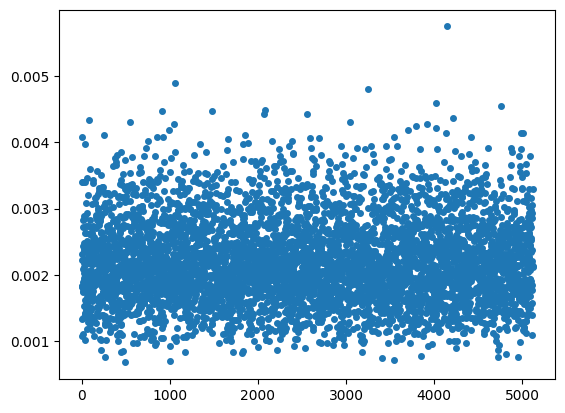

In [11]:
# output error along channels
plot_error(output_torch, output_jax_0)

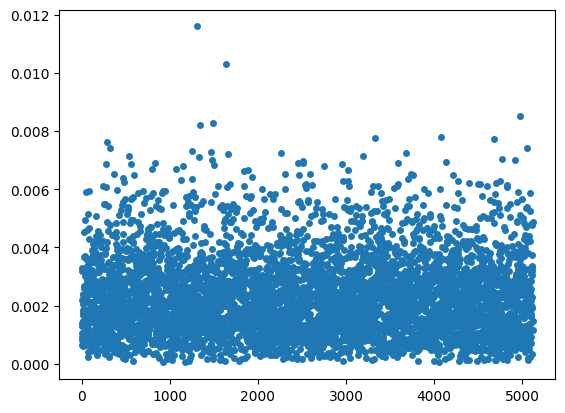

In [12]:
# Pytorch conv weight grad error along channels
plot_error(grads_GT, grad_torch)

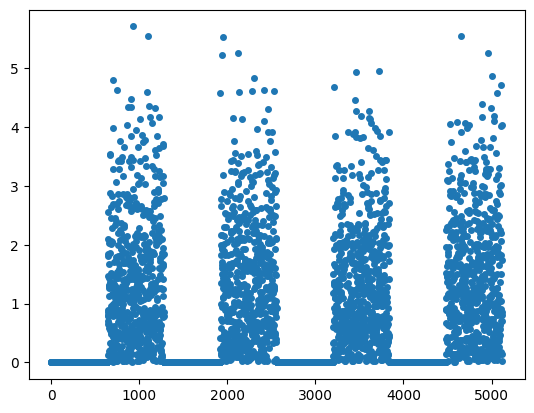

In [13]:
# FLAX conv weight grad error along channels
plot_error(grads_GT, grad_jax_0)

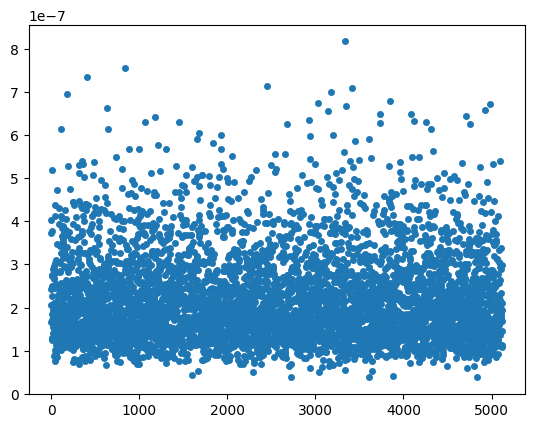

In [14]:
# FLAX conv weight grad error along channels
plot_error(grads_GT, grad_jax_1)